# Project 5 (Group) - Georgia State Recidivism: Binary Classification Forecasting

## Notebook Summary
---
This contents of this notebook includes the problem statement, background research, & pre-processing/data cleaning

## Problem Statement
---

The National Institute of Justice and the US Office of Justice Programs are looking to address recidivism rates by predicting persons most at risk. The focus of this project is to identify key variables that increase the probability a person will recidivate. Using a binary classification, can predictive attributes be identified and used to create solutions that can reduce prison reentry rates?

## Background & Outside Research
---

### Project Websites
- "NIJ's Recidivism Challenge Full Dataset." Office of Justice Programs, U.S. Department of Justice, [Source](data.ojp.usdoj.gov/Courts/NIJ-s-Recidivism-Challenge-Full-Dataset/ynf5-u8nk)
- "Recidivism Forecasting Challenge." National Institute of Justice, U.S. Department of Justice, [Source](nij.ojp.gov/funding/recidivism-forecasting-challenge#g0jtto)
- "Evaluating Reentry Programs: A User's Guide to Measuring Recidivism." Office of Justice Programs, U.S. Department of Justice, [Source](www.ojp.gov/pdffiles1/nij/304110.pdf)

#### Office of Justice Programs - NIJ Recidivism Challenge #### ([*source*](https://data.ojp.usdoj.gov/stories/s/daxx-hznc))
- The National Institute of Justice invests in scientific research across diverse disciplines to serve the needs of the criminal justice community.
- Many new data analytic methods could be further applied to the criminal justice system, specifically recidivism forecasting algorithms
- Since practitioners began to systematically assess risk, risk assessment tools have been constantly refined with new factors and types of data, including dynamic factors that capture current information regarding persons on probation and parole.
- Recidivism is measured as an arrest for a new felony or misdemeanor crime within three years of the supervision start date. 

### Datasets
---

The raw datasets are located inside the [`data`](./data/) folder for this project.
* [`NIJ_s_Recidivism_Challenge_Full_Dataset.csv`](./data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv): this dataset is the main dataset
* [`census_puma_data.csv`](./data/census_puma_data.csv): this is a supplemental dataset

--- 
# Part 1 - Data Cleaning/Pre-Processing

---

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
recid_df = pd.read_csv('./data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')
recid_df.columns = [x.lower() for x in recid_df]
recid_df.shape

(25835, 54)

In [3]:
recid_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,25835.0,13314.004838,7722.206327,1.0,6626.500000,13270.000000,20021.500000,26761.0
residence_puma,25835.0,12.361796,7.133742,1.0,6.000000,12.000000,18.000000,25.0
supervision_risk_score_first,25360.0,6.082216,2.381442,1.0,4.000000,6.000000,8.000000,10.0
avg_days_per_drugtest,19732.0,93.890044,117.169847,0.5,28.837366,55.424812,110.333333,1088.5
drugtests_thc_positive,20663.0,0.063350,0.138453,0.0,0.000000,0.000000,0.071429,1.0
drugtests_cocaine_positive,20663.0,0.013741,0.061233,0.0,0.000000,0.000000,0.000000,1.0
drugtests_meth_positive,20663.0,0.012890,0.060581,0.0,0.000000,0.000000,0.000000,1.0
drugtests_other_positive,20663.0,0.007550,0.041150,0.0,0.000000,0.000000,0.000000,1.0
percent_days_employed,25373.0,0.482331,0.425004,0.0,0.000000,0.475728,0.969325,1.0
jobs_per_year,25027.0,0.769295,0.813787,0.0,0.000000,0.635217,1.000000,8.0


### Outliers
'avg_days_per_drugtest' looks to have a large max value. check for outliers through scatterplot

1

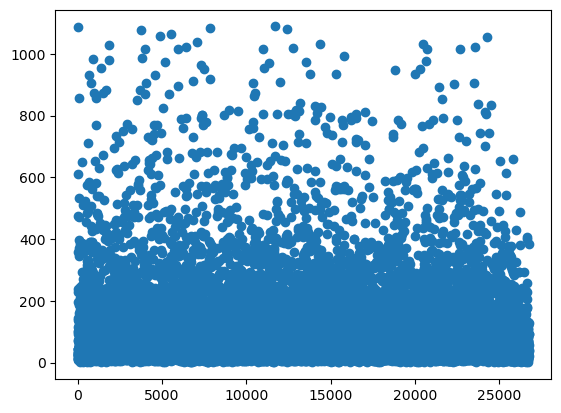

In [4]:
plt.scatter(y = recid_df['avg_days_per_drugtest'], x = recid_df['id']);1

No standout outliers seen.

### Nulls

#### Potential Ways to Handle Nulls
Note: KNN doesn't expect data to be normally distributed, but iterativeimputer does, but we have a lot of cols so it might not be super important

**pre train-test-split**
<!-- - prison_offense - 12.7% of the data - drop nulls bc this will prob be highly correlated with other cols that'll capture -->

**post train-test-split**

KNNimputer
- gang_affiliated - 12% of the data, initial thinking is to drop OR knn imputer

-Impute with Mean
- supervision_risk_score_first - pretty normal distribution, use mean

-Impute with most frequent
- supervision_level_first - 7% of the data - most frequent - 'Standard', use mode

In [5]:
nulls = pd.DataFrame(recid_df.isna().sum())
nulls = nulls.loc[nulls[0] != 0]
nulls

,0
gang_affiliated,3167
supervision_risk_score_first,475
supervision_level_first,1720
prison_offense,3277
avg_days_per_drugtest,6103
drugtests_thc_positive,5172
drugtests_cocaine_positive,5172
drugtests_meth_positive,5172
drugtests_other_positive,5172
percent_days_employed,462


'drug' columns there is a theme: no 0 values so NAN must represent 0.

In [6]:
drug_cols = recid_df.filter(like='drugtest').columns
recid_df[drug_cols] = recid_df[drug_cols].fillna(0)

'prison_offense' NANs will be dropped. Account for  12.8% of the total data and in addition it would be impossible to impute accurately.

In [7]:
recid_df.dropna(subset ='prison_offense', inplace = True)

'jobs_per_year' and 'percent_days_employed' are very similar and because of this we can choose one to keep. A better metric of employement would be percent_days since it relates to total time instead of 'jobs_per_year' . Dropping 'jobs_per_year' also removes the higher NaN value catergory.

In [8]:
recid_df.drop(columns = 'jobs_per_year',inplace = True)

'percent_days_employed' is 2% of the data and would be difficult to impute accurately. Drop rows with NaNs.

In [9]:
recid_df.dropna(subset = ['percent_days_employed'],inplace = True)

Check distributions of remaining nulls

<AxesSubplot:xlabel='supervision_risk_score_first', ylabel='Count'>

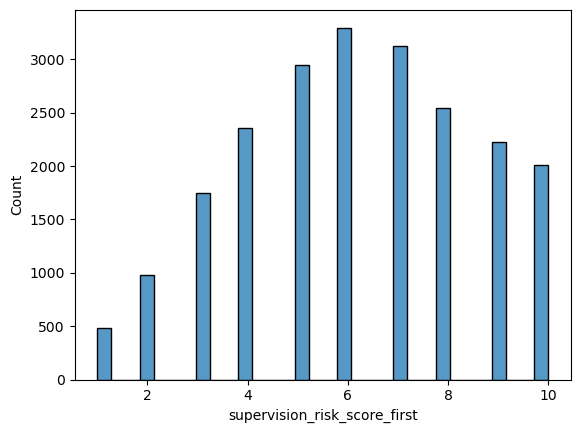

In [10]:
sns.histplot(data=recid_df,x='supervision_risk_score_first')

<AxesSubplot:xlabel='supervision_level_first', ylabel='Count'>

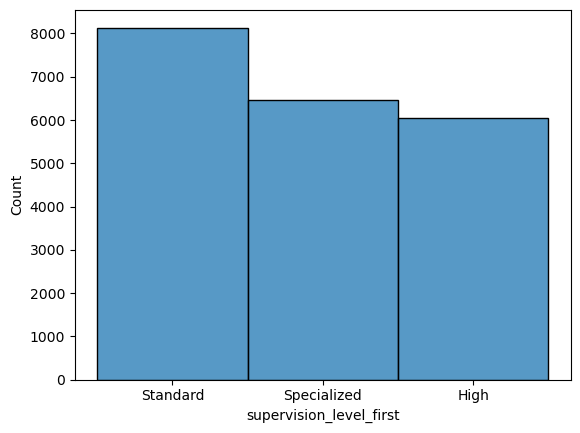

In [11]:
sns.histplot(data=recid_df,x='supervision_level_first')

How to Deal with remaing null values based on distributions:

- KNNimputer: gang_affiliated - 12% of the data, initial thinking is to drop OR knn imputer
- Impute with Mean: supervision_risk_score_first (normal distribution)
- Impute with most frequent: supervision_level_first - 7% of the data - most frequent 

## Binary Columns to Numeric

####  Converting booleans to binary values true 1- false 0

In [12]:
for cols in recid_df.select_dtypes(include = ['bool']).columns:
    recid_df[cols].replace({True: 1, False: 0}, inplace=True)

#### Convert M to 1 and F to 0  for gender and BLACK to 1 and WHITE to 0  for race

In [13]:
recid_df['gender'].replace({'M': 1, 'F': 0}, inplace=True)
recid_df['race'].replace({'BLACK': 1, 'WHITE': 0}, inplace=True)

#### Converting 'Dependents' from ordinal to Binary/Numeric
Dependents becomes binary through this transformation

In [14]:
recid_df['dependents'].replace({'0': 0, '1': 1, '2': 1, '3 or more': 1}, inplace=True)
recid_df.rename({'dependents': 'has_dependents'}, inplace=True)

## Train and Test Split
The data was already split (70/30) into train_test_split for the challenge

In [15]:
recid_df['training_sample'].value_counts(normalize=True)

1    0.697009
0    0.302991
Name: training_sample, dtype: float64

Split on the 'training_sample' identifiction 

In [16]:
train = recid_df.loc[recid_df['training_sample'] == 1]
test = recid_df.loc[recid_df['training_sample'] == 0]

Set the X variables by droppingn 'targets' and 'training_sample' columns

In [17]:
target_cols = ['recidivism_within_3years','recidivism_arrest_year1', 'recidivism_arrest_year2', 'recidivism_arrest_year3', 'training_sample']

X_train_df = train.drop(columns = target_cols)
X_test_df = test.drop(columns = target_cols)

Set the y variables by chosing the target variable and ID for identification later 

In [18]:
features = ['id','recidivism_within_3years']

y_train = train[features]
y_test = test[features]

## Impute Missing Values
Now that the data is split, no data will bleed when imputing. Each train and test dataframe will be imputted

### Impute supervision_risk_score_first (mean) & supervision_level_first (mode)

In [20]:
#impute mean
imputer1 = SimpleImputer(strategy='mean')

#impute most_frequent
imputer2 = SimpleImputer(strategy="most_frequent")

#make column transformer to feed each column into its respective imputer
imputer = make_column_transformer((imputer1,['supervision_risk_score_first']),
                                  (imputer2,['supervision_level_first']),
                                  remainder='passthrough',
                                  verbose_feature_names_out=False)
#apply fit transform to train set
imputer.fit_transform(X_train_df)

#convert to df
X_train_df_imp = pd.DataFrame(imputer.fit_transform(X_train_df), columns= imputer.get_feature_names_out(), index=X_train_df.index)

In [21]:
#apply fit and transformer to test df
imputer.fit_transform(X_test_df)

#convert to df
X_test_df_imp = pd.DataFrame(imputer.fit_transform(X_test_df), columns= imputer.get_feature_names_out(), index=X_test_df.index)

In [27]:
# X_train_df.select_dtypes(['object'])

### Encode Categorical Columns
Encoding must happen in order to properly KNN impute on the 'gang_relation' column

In [28]:
#unique vals for cols to turn to ordinal vals
cols_to_numeric = ['prior_arrest_episodes_felony',
                   'prior_arrest_episodes_misd',
                   'prior_arrest_episodes_violent',
                   'prior_arrest_episodes_property',
                   'prior_arrest_episodes_drug',
                   'prior_arrest_episodes_ppviolationcharges',
                   'prior_conviction_episodes_felony',
                   'prior_conviction_episodes_misd',
                   'prior_conviction_episodes_prop',
                   'prior_conviction_episodes_drug',
                   'delinquency_reports',
                   'program_unexcusedabsences',
                   'program_attendances',
                   'residence_changes']

# strip 'or more' from all vals from the cols above train
for c in cols_to_numeric:
    X_train_df_imp[c] = X_train_df_imp[c].str.strip(' or more')
    
    # strip 'or more' from all vals from the cols above test
for c in cols_to_numeric:
    X_test_df_imp[c] = X_test_df_imp[c].str.strip(' or more')

In [29]:
#converting these columns to numeric train
for c in cols_to_numeric:
    X_train_df_imp[c] = pd.to_numeric(X_train_df_imp[c])
    
#converting these columns to numeric test
for c in cols_to_numeric:
    X_test_df_imp[c] = pd.to_numeric(X_test_df_imp[c])

### Converting select object columns to numeric
Strange thing happened so we must again change the column types to numeric and cleaning up clerical issues with 'supervision_risk_score_first'

In [30]:
#changing incorrect dtypes for cols from obj to numeric

obj_to_numeric = ['gender', 'race', 'dependents', 'prior_arrest_episodes_dvcharges', 'prior_arrest_episodes_guncharges',
       'prior_conviction_episodes_viol',
       'prior_conviction_episodes_ppviolationcharges',
       'prior_conviction_episodes_domesticviolencecharges',
       'prior_conviction_episodes_guncharges', 'prior_revocations_parole',
       'prior_revocations_probation', 'condition_mh_sa', 'condition_cog_ed',
       'condition_other', 'violations_electronicmonitoring',
       'violations_instruction', 'violations_failtoreport',
       'violations_movewithoutpermission','employment_exempt', 'avg_days_per_drugtest',
       'drugtests_thc_positive', 'drugtests_cocaine_positive',
       'drugtests_meth_positive', 'drugtests_other_positive',
       'percent_days_employed', 'supervision_risk_score_first']

In [31]:
#converting these columns to numeric on train/test
for c in obj_to_numeric:
    X_train_df_imp[c] = pd.to_numeric(X_train_df_imp[c])
    
for c in obj_to_numeric:
    X_test_df_imp[c] = pd.to_numeric(X_test_df_imp[c])

In [32]:
#going to convert into integers based on what the data dict says - should be 1-10 score
X_train_df_imp['supervision_risk_score_first'].value_counts(normalize=True)

6.000000     0.149135
7.000000     0.143172
5.000000     0.130015
8.000000     0.114913
4.000000     0.107719
9.000000     0.100395
10.000000    0.088211
3.000000     0.080109
2.000000     0.044980
1.000000     0.021972
6.154461     0.019379
Name: supervision_risk_score_first, dtype: float64

In [33]:
X_train_df_imp['supervision_risk_score_first'] = X_train_df_imp['supervision_risk_score_first'].astype(int)
X_test_df_imp['supervision_risk_score_first'] = X_test_df_imp['supervision_risk_score_first'].astype(int)

### OHE Select Categorical Columns
Checking correct columns are returned as 'object'

In [34]:
X_train_df_imp.select_dtypes(['object']).head(3)

,supervision_level_first,id,age_at_release,residence_puma,gang_affiliated,education_level,prison_offense,prison_years
0,Standard,1,43-47,16,False,At least some college,Drug,More than 3 years
1,Specialized,2,33-37,16,False,Less than HS diploma,Violent/Non-Sex,More than 3 years
2,High,3,48 or older,24,False,At least some college,Drug,1-2 years


In [35]:
#instantiate OHE
ohe = OneHotEncoder(sparse=False, drop='if_binary')

#list of cols to dummy
cols_to_ohe = ['residence_puma',
               'age_at_release',
               'supervision_level_first',
               'education_level',
               'prison_offense',
               'prison_years']

#create transformer to apply OHE to select cols only
transformer = make_column_transformer((ohe, cols_to_ohe),
                                      remainder = 'passthrough',
                                      verbose_feature_names_out = False)

#apply the transformer to both train and test
transformer.fit_transform(X_train_df_imp)
transformer.transform(X_test_df_imp)

#convert to dataframe
X_train_encoded = pd.DataFrame(transformer.fit_transform(X_train_df_imp), columns = transformer.get_feature_names_out(), index=X_train_df_imp.index)
X_test_encoded = pd.DataFrame(transformer.transform(X_test_df_imp), columns = transformer.get_feature_names_out(), index=X_test_df_imp.index)

### Scale Data
Scale all encoded and converted data for KNN imputer modeling

In [36]:
#instantiate sc
sc = StandardScaler()

#list of cols
cols_to_scale = X_train_encoded.drop(columns=['id','gang_affiliated']).columns.values

#create transformer to apply OHE to select ols only
scaler = make_column_transformer((sc, cols_to_scale),
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False)

#fit transform 
Z_train = scaler.fit_transform(X_train_encoded)
Z_test = scaler.transform(X_test_encoded)

#turn into df
Z_train = pd.DataFrame(Z_train, columns=scaler.get_feature_names_out(), index=X_train_encoded.index)
Z_test = pd.DataFrame(Z_test, columns=scaler.get_feature_names_out(), index=X_test_encoded.index)

### KNNImputer for 'gang_affiliated' Nulls
Fill nulls for gang_affiliated and do a final scaling since it is the only column not scaled. KNN is not predicting 1 or 0 for the values but rather the average of the neighbors so the values will be rounded from the nearest Intger.

In [37]:
#instantiate KNNImputer for train
knn_imp = KNNImputer()
#instantiate KNNImputer for test 
knn_imp2 = KNNImputer()

#fit and transform for train
X_train_knn = knn_imp.fit_transform(Z_train)
#fit and transform for test
X_test_knn = knn_imp2.fit_transform(Z_test)

#convert to df
X_train_knn = pd.DataFrame(X_train_knn,columns = Z_train.columns, index=Z_train.index)
#convert to df
X_test_knn = pd.DataFrame(X_test_knn,columns = Z_test.columns, index=Z_test.index)

#checking that nulls were filled in
print(X_train_knn['gang_affiliated'].isna().sum())
print(X_test_knn['gang_affiliated'].isna().sum())

#rounding vals for 'gang_affiliated' cols
X_train_knn['gang_affiliated'] = X_train_knn[['gang_affiliated']].round()
X_test_knn['gang_affiliated'] = X_test_knn[['gang_affiliated']].round()

0
0


In [38]:
#instantiate sc
sc2 = StandardScaler()

#list of cols
cols_to_scale = X_train_knn.drop(columns=['id']).columns.values

#create transformer to apply OHE to select ols only
scaler2 = make_column_transformer((sc2, cols_to_scale),
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False)

#fit transform 
X_train_final = scaler2.fit_transform(X_train_knn)
X_test_final = scaler2.transform(X_test_knn)

#turn into df
X_train_final = pd.DataFrame(X_train_final, columns=scaler2.get_feature_names_out(), index=X_train_knn.index)
X_test_final = pd.DataFrame(X_test_final, columns=scaler2.get_feature_names_out(), index=X_test_knn.index)

In [39]:
#Export to csv
#X_train_final.to_csv('./cleaned_data/X_train_final.csv')
#X_test_final.to_csv('./cleaned_data/X_test_final.csv')
#y_train.to_csv('./cleaned_data/y_train.csv')
#y_test.to_csv('./cleaned_data/y_test.csv')

In [40]:
X_train_final.head()

,residence_puma_1,residence_puma_2,residence_puma_3,residence_puma_4,residence_puma_5,residence_puma_6,residence_puma_7,residence_puma_8,residence_puma_9,residence_puma_10,...,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,employment_exempt,gang_affiliated,id
0,-0.183763,-0.210893,-0.234927,-0.260432,-0.214059,-0.212897,-0.217513,-0.261424,-0.163142,-0.151682,...,1.131788,4.922330,-0.398177,-0.200406,-0.194036,-0.162822,0.016395,-0.399112,-0.445491,1.0
1,-0.183763,-0.210893,-0.234927,-0.260432,-0.214059,-0.212897,-0.217513,-0.261424,-0.163142,-0.151682,...,1.131788,-0.331993,-0.398177,-0.200406,-0.194036,-0.162822,-0.132771,-0.399112,-0.445491,2.0
2,-0.183763,-0.210893,-0.234927,-0.260432,-0.214059,-0.212897,-0.217513,-0.261424,-0.163142,-0.151682,...,-0.812146,0.196782,2.221204,-0.200406,2.913829,-0.162822,-1.134383,-0.399112,-0.445491,3.0
3,-0.183763,-0.210893,-0.234927,-0.260432,-0.214059,-0.212897,-0.217513,-0.261424,-0.163142,-0.151682,...,2.103754,-0.425592,-0.398177,-0.200406,-0.194036,-0.162822,1.221056,-0.399112,-0.445491,4.0
4,-0.183763,-0.210893,-0.234927,-0.260432,-0.214059,-0.212897,-0.217513,-0.261424,-0.163142,-0.151682,...,-0.812146,-0.446400,-0.398177,-0.200406,0.902857,-0.162822,-0.654904,-0.399112,-0.445491,5.0


### Correlations

In [41]:
# #plot correlation of features to target val
# plt.figure(figsize=(6,12))
# sns.heatmap(pd.merge(X_train_knn, y_train, on='id').corr()[['recidivism_within_3years']].sort_values('recidivism_within_3years', ascending=False),
#             annot=True);

'percent_days_employed','employment_exempt', check to see if there is a theme between being exempt and working. Largest group is not exempt and 0 days worked. Pointing to a possible relationship to positive recidism  Could be clerical differences in how work is measured here. When looking at distribution the majority of the classes are in the 1 and 0 groups.

In [42]:
employ_cols = ['percent_days_employed','employment_exempt']
recid_df[employ_cols].value_counts(normalize = True)

percent_days_employed  employment_exempt
0.000000               0                    0.277015
1.000000               0                    0.184857
0.000000               1                    0.044317
1.000000               1                    0.020239
0.500000               0                    0.000497
                                              ...   
0.420485               0                    0.000045
0.420502               0                    0.000045
0.420945               0                    0.000045
0.421209               0                    0.000045
0.629335               1                    0.000045
Length: 9815, dtype: float64